1. Import the required libraries.

In [21]:
import numpy as np
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Conv2D, Concatenate, Dense, Dropout, Flatten, MaxPooling2D, ReLU, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import categorical_crossentropy

In [22]:
import keras

2. Load the Dataset

In [23]:
train = tf.keras.utils.image_dataset_from_directory('train')
val = tf.keras.utils.image_dataset_from_directory('validation')
test = tf.keras.utils.image_dataset_from_directory('test')

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


In [25]:
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 32 

In [28]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory('train',
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 3115 images belonging to 36 classes.


In [29]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory('validation',
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 351 images belonging to 36 classes.


In [30]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : apple
1 : banana
2 : beetroot
3 : bell pepper
4 : cabbage
5 : capsicum
6 : carrot
7 : cauliflower
8 : chilli pepper
9 : corn
10 : cucumber
11 : eggplant
12 : garlic
13 : ginger
14 : grapes
15 : jalepeno
16 : kiwi
17 : lemon
18 : lettuce
19 : mango
20 : onion
21 : orange
22 : paprika
23 : pear
24 : peas
25 : pineapple
26 : pomegranate
27 : potato
28 : raddish
29 : soy beans
30 : spinach
31 : sweetcorn
32 : sweetpotato
33 : tomato
34 : turnip
35 : watermelon


3. Plot Sample Training.

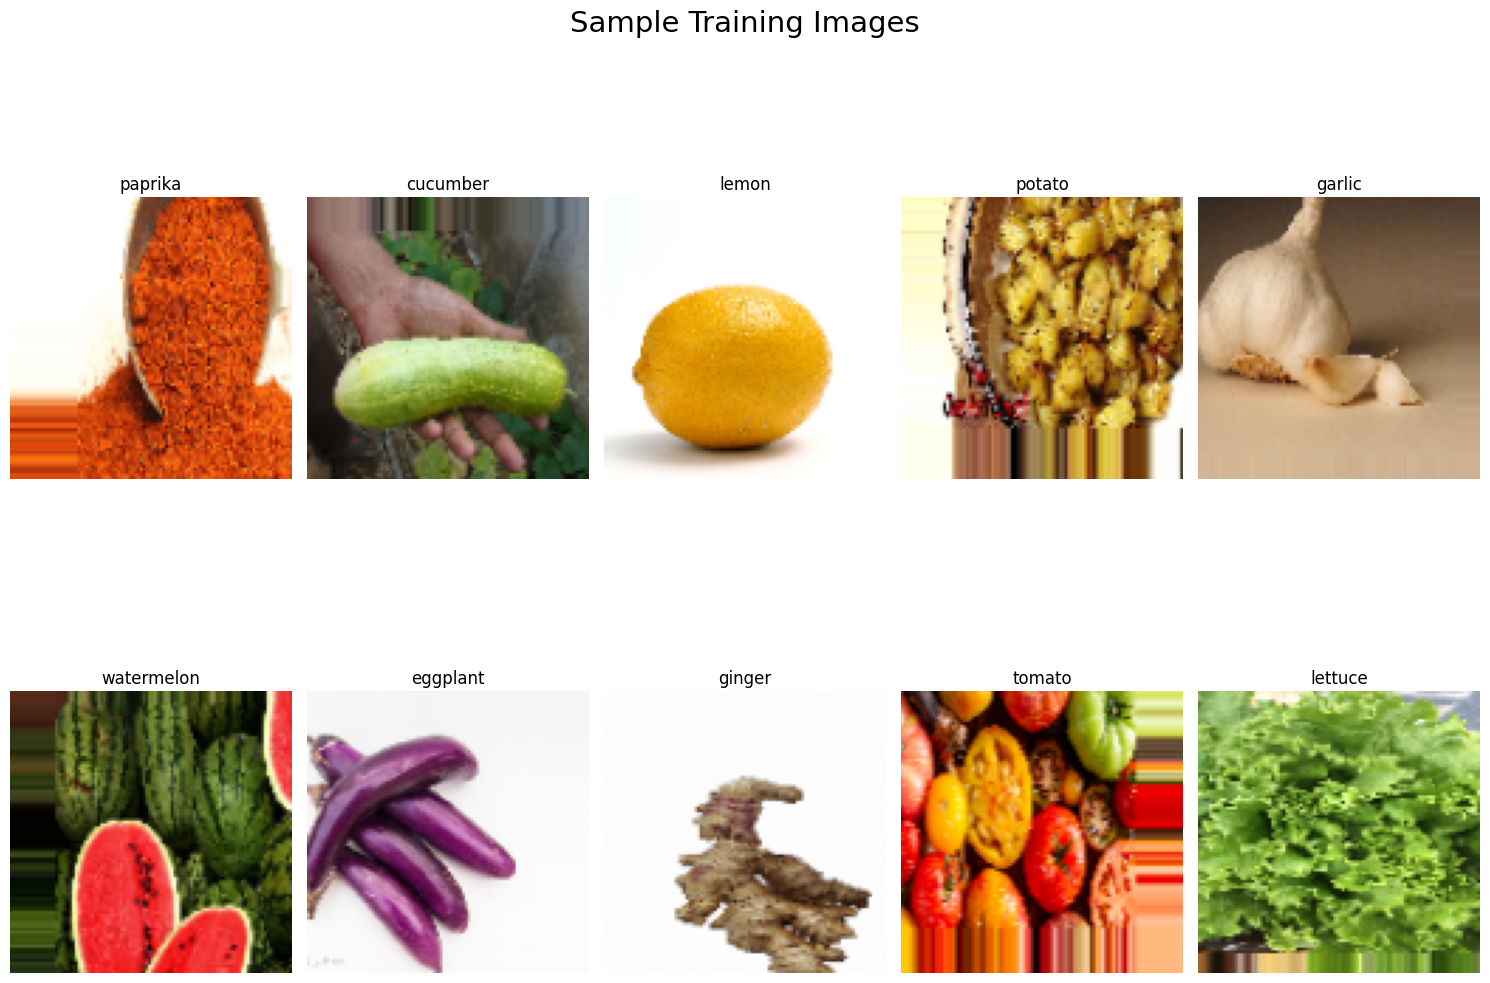

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [33]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 100, 100, 3)
(128, 36)


4. Create and Train the CNN model.

In [68]:
def create_conv(img_path='network1.png'):
    inp = Input((100, 100, 3))
    conv2d_1 = Conv2D(
        filters = 16,
        kernel_size = (3, 3),
        strides =(1),
        padding = 'SAME', 
        activation = 'relu')(inp)
    BatchNormalization()
    b1 = BatchNormalization()(conv2d_1)
    r1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b1)
    pool = MaxPooling2D((2,2), padding='same')(r1)

    conv2d_2 = Conv2D(
        filters = 16,
        kernel_size = (5, 5),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(r1)
    b2 = BatchNormalization()(conv2d_2)
    r2 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b2)
    #first block-----------------

    conv2d_3 = Conv2D(
        filters = 16,
        kernel_size = (3, 3),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(r2)
    b3 = BatchNormalization()(conv2d_3)
    r3 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b3)
    conv2d_4 = Conv2D(
        filters = 16,
        kernel_size = (5, 5),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(r2)
    b4 = BatchNormalization()(conv2d_4)
    r4 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b4)
    conv2d_5 = Conv2D(
        filters = 16,
        kernel_size = (7, 7),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(r2)
    b5 = BatchNormalization()(conv2d_5)
    r5 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b5)
    conv2d_6 = Conv2D(
        filters = 16,
        kernel_size = (11, 11),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(r2)
    BatchNormalization()
    b6 = BatchNormalization()(conv2d_6)
    r6 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b6)

    CN1 = Concatenate()([r2, r3, r4, r5, r6])
    bx1 = BatchNormalization()(CN1)
    BatchNormalization()
    pool1 = MaxPooling2D((2,2), padding='same')(bx1)

    #Second block-----------------

    conv2d_7 = Conv2D(
        filters = 32,
        kernel_size = (3, 3),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx1)
    BatchNormalization()
    b7 = BatchNormalization()(conv2d_7)
    r7 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b7)
    conv2d_8 = Conv2D(
        filters = 32,
        kernel_size = (5, 5),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx1)
    BatchNormalization()
    b8 = BatchNormalization()(conv2d_8)
    r8 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b8)
    conv2d_9 = Conv2D(
        filters = 32,
        kernel_size = (7, 7),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx1)
    BatchNormalization()
    b9 = BatchNormalization()(conv2d_9)
    r9 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b9)
    conv2d_10 = Conv2D(
        filters = 32,
        kernel_size = (11, 11),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx1)
    b10 = BatchNormalization()(conv2d_10)
    r10 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b10)

    CN2 = Concatenate()([r7, r8, r9, r10])
    bx2 = BatchNormalization()(CN2)
    pool2 = MaxPooling2D((2,2), padding='same')(bx2)

    #Third block-----------------

    conv2d_11 = Conv2D(
        filters = 32,
        kernel_size = (3, 3),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(bx2)
    b11 = BatchNormalization()(conv2d_11)
    r11 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b11)
    conv2d_12 = Conv2D(
        filters = 32,
        kernel_size = (5, 5),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(bx2)
    b12 = BatchNormalization()(conv2d_12)
    r12 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b12)
    conv2d_13 = Conv2D(
        filters = 32,
        kernel_size = (7, 7),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(bx2)
    b13 = BatchNormalization()(conv2d_13)
    r13 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b13)
    conv2d_14 = Conv2D(
        filters = 32,
        kernel_size = (11, 11),
        strides =(1),
        padding = 'SAME',
        activation = 'relu')(bx2)
    b14 = BatchNormalization()(conv2d_14)
    r14 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b14)

    CN3 = Concatenate()([bx2, r11, r12, r13, r14])
    bx3 = BatchNormalization()(CN3)
    pool3 = MaxPooling2D((2,2), padding='same')(bx3)

    #Fourth block-----------------

    conv2d_15 = Conv2D(
        filters = 64,
        kernel_size = (3, 3),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx3)
    b15 = BatchNormalization()(conv2d_15)
    r15 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b15)
    conv2d_16 = Conv2D(
        filters = 64,
        kernel_size = (5, 5),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx3)
    b16 = BatchNormalization()(conv2d_16)
    r16 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b16)
    conv2d_17 = Conv2D(
        filters = 64,
        kernel_size = (7, 7),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx3)
    b17 = BatchNormalization()(conv2d_17)
    r17 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b17)
    conv2d_18 = Conv2D(
        filters = 64,
        kernel_size = (11, 11),
        strides =(2),
        padding = 'SAME',
        activation = 'relu')(bx3)
    b18 = BatchNormalization()(conv2d_18)
    r18 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b18)

    poolx = MaxPooling2D((8,8), padding='same')(bx1)
    conv2d_19 = Conv2D(
        filters = 64,
        kernel_size = (7, 7),
        strides =(4),
        padding = 'SAME',
        activation = 'relu')(bx1)
    b19 = BatchNormalization()(conv2d_19)
    r19 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(b19)


    CN4 = Concatenate()([r15, r16, r17, r18, r19])
    bx4 = BatchNormalization()(CN4)
    
    a1 = AveragePooling2D((7,7), strides= 2)(bx4)
    flatten = Flatten()(a1)
    fc1 = Dense(300, activation='relu')(flatten)
    dropout1 = Dropout(0.5)(fc1)
    fc2 = Dense(200, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(fc2)
    fc3 = Dense(36, activation='relu')(dropout2)
    output = Dense(36, activation='softmax')(fc3)


    model = tf.keras.models.Model(inputs=inp, outputs=output)
    print(len(model.layers))
    tf.keras.utils.plot_model(model, to_file=img_path)
    return model

In [69]:
tf.keras.backend.clear_session()

In [70]:
cnn = create_conv()

74


In [71]:
print(cnn.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 100, 100, 16  64         ['conv2d[0][0]']                 
 rmalization)                   )                                                             

In [72]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [73]:
optimizer = Adam(learning_rate=0.001)

In [74]:
cnn.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [75]:
history = cnn.fit(train_generator, epochs=100, validation_data=validation_generator,
                       verbose=2)

Epoch 1/100
25/25 - 277s - loss: 3.8520 - accuracy: 0.0360 - val_loss: 3.6027 - val_accuracy: 0.0313 - 277s/epoch - 11s/step
Epoch 2/100
25/25 - 262s - loss: 3.6210 - accuracy: 0.0507 - val_loss: 3.5896 - val_accuracy: 0.0399 - 262s/epoch - 10s/step
Epoch 3/100
25/25 - 261s - loss: 3.5207 - accuracy: 0.0709 - val_loss: 3.6093 - val_accuracy: 0.0313 - 261s/epoch - 10s/step
Epoch 4/100
25/25 - 262s - loss: 3.4141 - accuracy: 0.0921 - val_loss: 3.7634 - val_accuracy: 0.0313 - 262s/epoch - 10s/step
Epoch 5/100
25/25 - 261s - loss: 3.3239 - accuracy: 0.1127 - val_loss: 3.5798 - val_accuracy: 0.0484 - 261s/epoch - 10s/step
Epoch 6/100
25/25 - 261s - loss: 3.2312 - accuracy: 0.1255 - val_loss: 3.6773 - val_accuracy: 0.0285 - 261s/epoch - 10s/step
Epoch 7/100
25/25 - 261s - loss: 3.1059 - accuracy: 0.1441 - val_loss: 4.1398 - val_accuracy: 0.0285 - 261s/epoch - 10s/step
Epoch 8/100
25/25 - 262s - loss: 2.9923 - accuracy: 0.1647 - val_loss: 4.3841 - val_accuracy: 0.0427 - 262s/epoch - 10s/step


In [76]:
# Save the trained model
cnn.save('model.h5')

5. Plot the metrics needed.

In [78]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

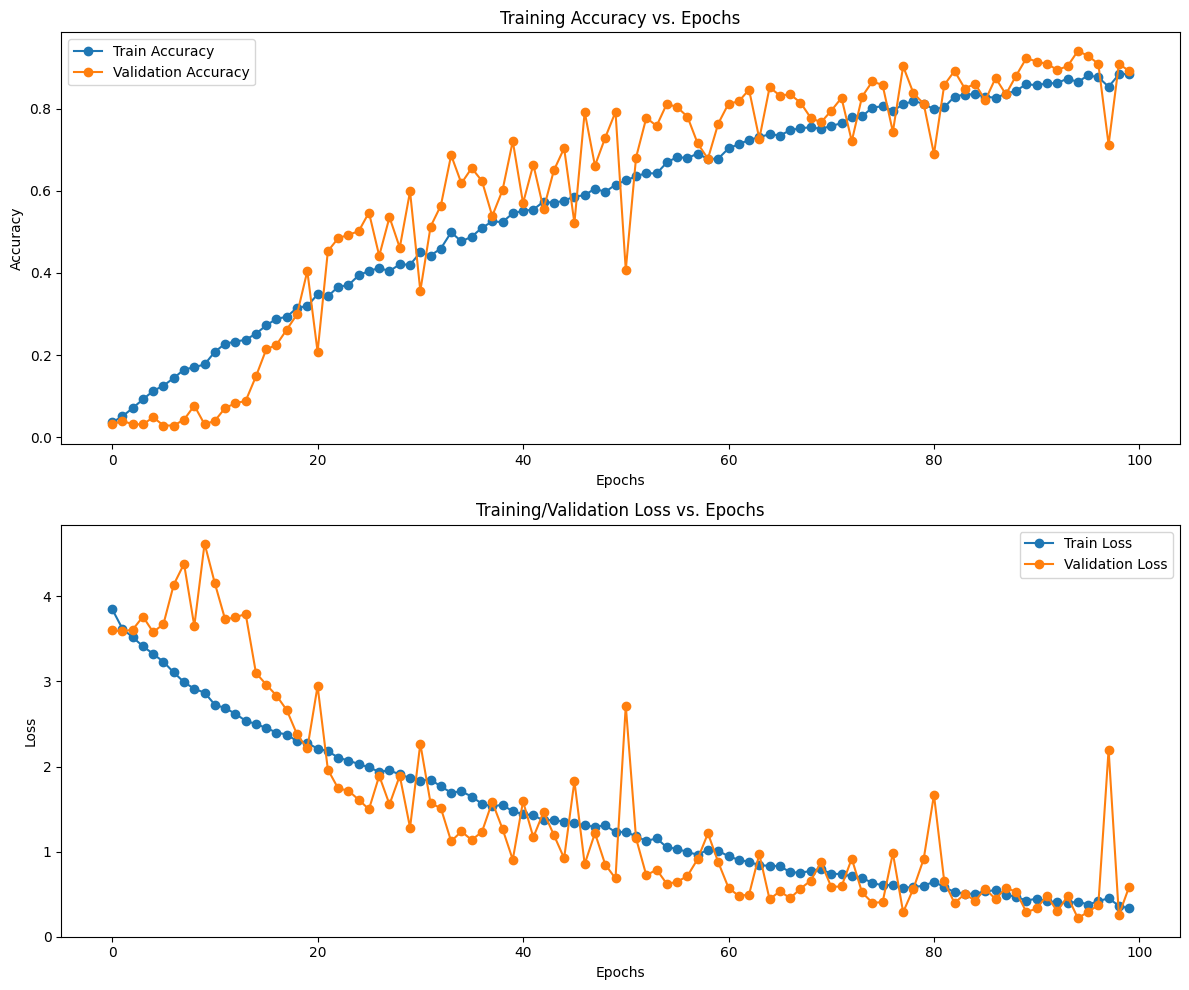

In [81]:

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

6. Test the model on test dataset.

In [83]:
test = tf.keras.utils.image_dataset_from_directory('test')

Found 359 files belonging to 36 classes.


In [85]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory('test',
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 359 images belonging to 36 classes.


7. Model predictions on the Test Dataset.

In [86]:
predictions = cnn.predict(test_generator)

3/3 [==============================] - 14s 5s/step


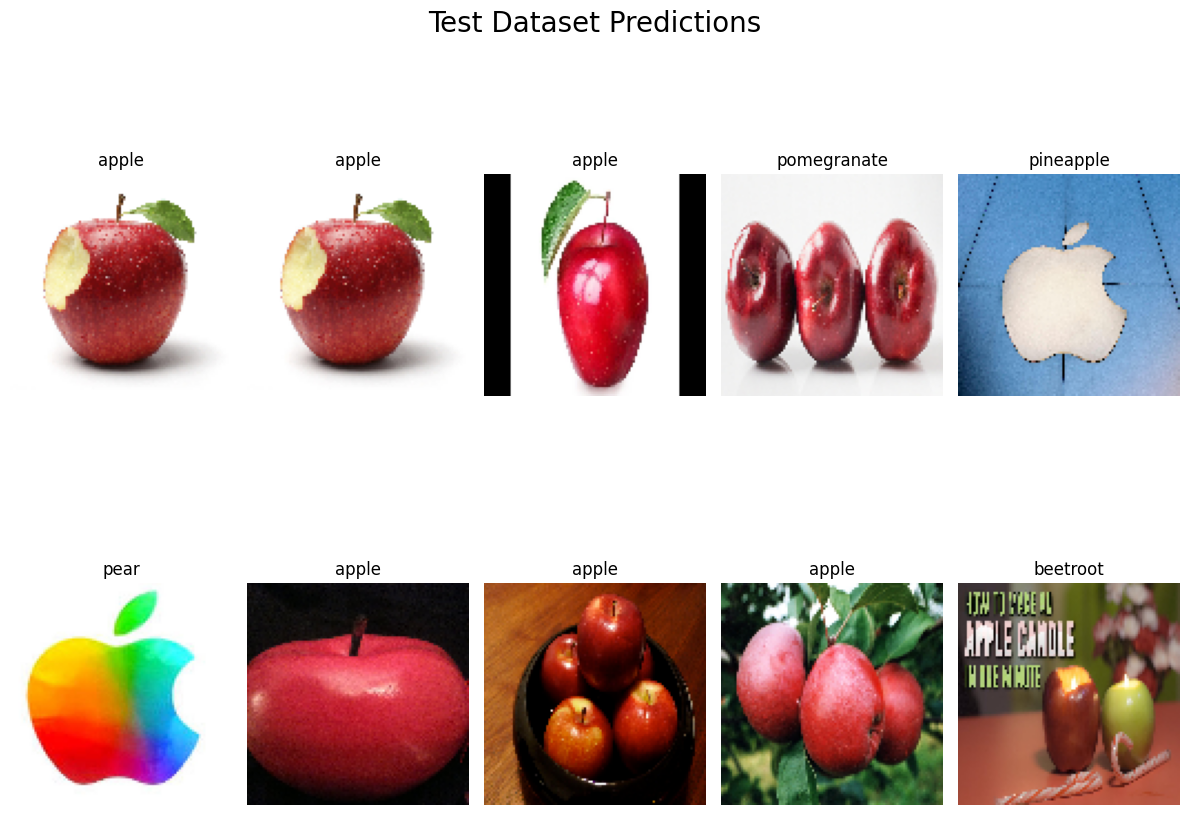

In [87]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [88]:
test_loss, test_accuracy = cnn.evaluate(test_generator, batch_size=BATCH_SIZE)

3/3 [==============================] - 10s 3s/step - loss: 0.6865 - accuracy: 0.8914


In [89]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.686515212059021
Test Accuracy: 0.8913649320602417


8. Plotting the confusion matrix.

In [90]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

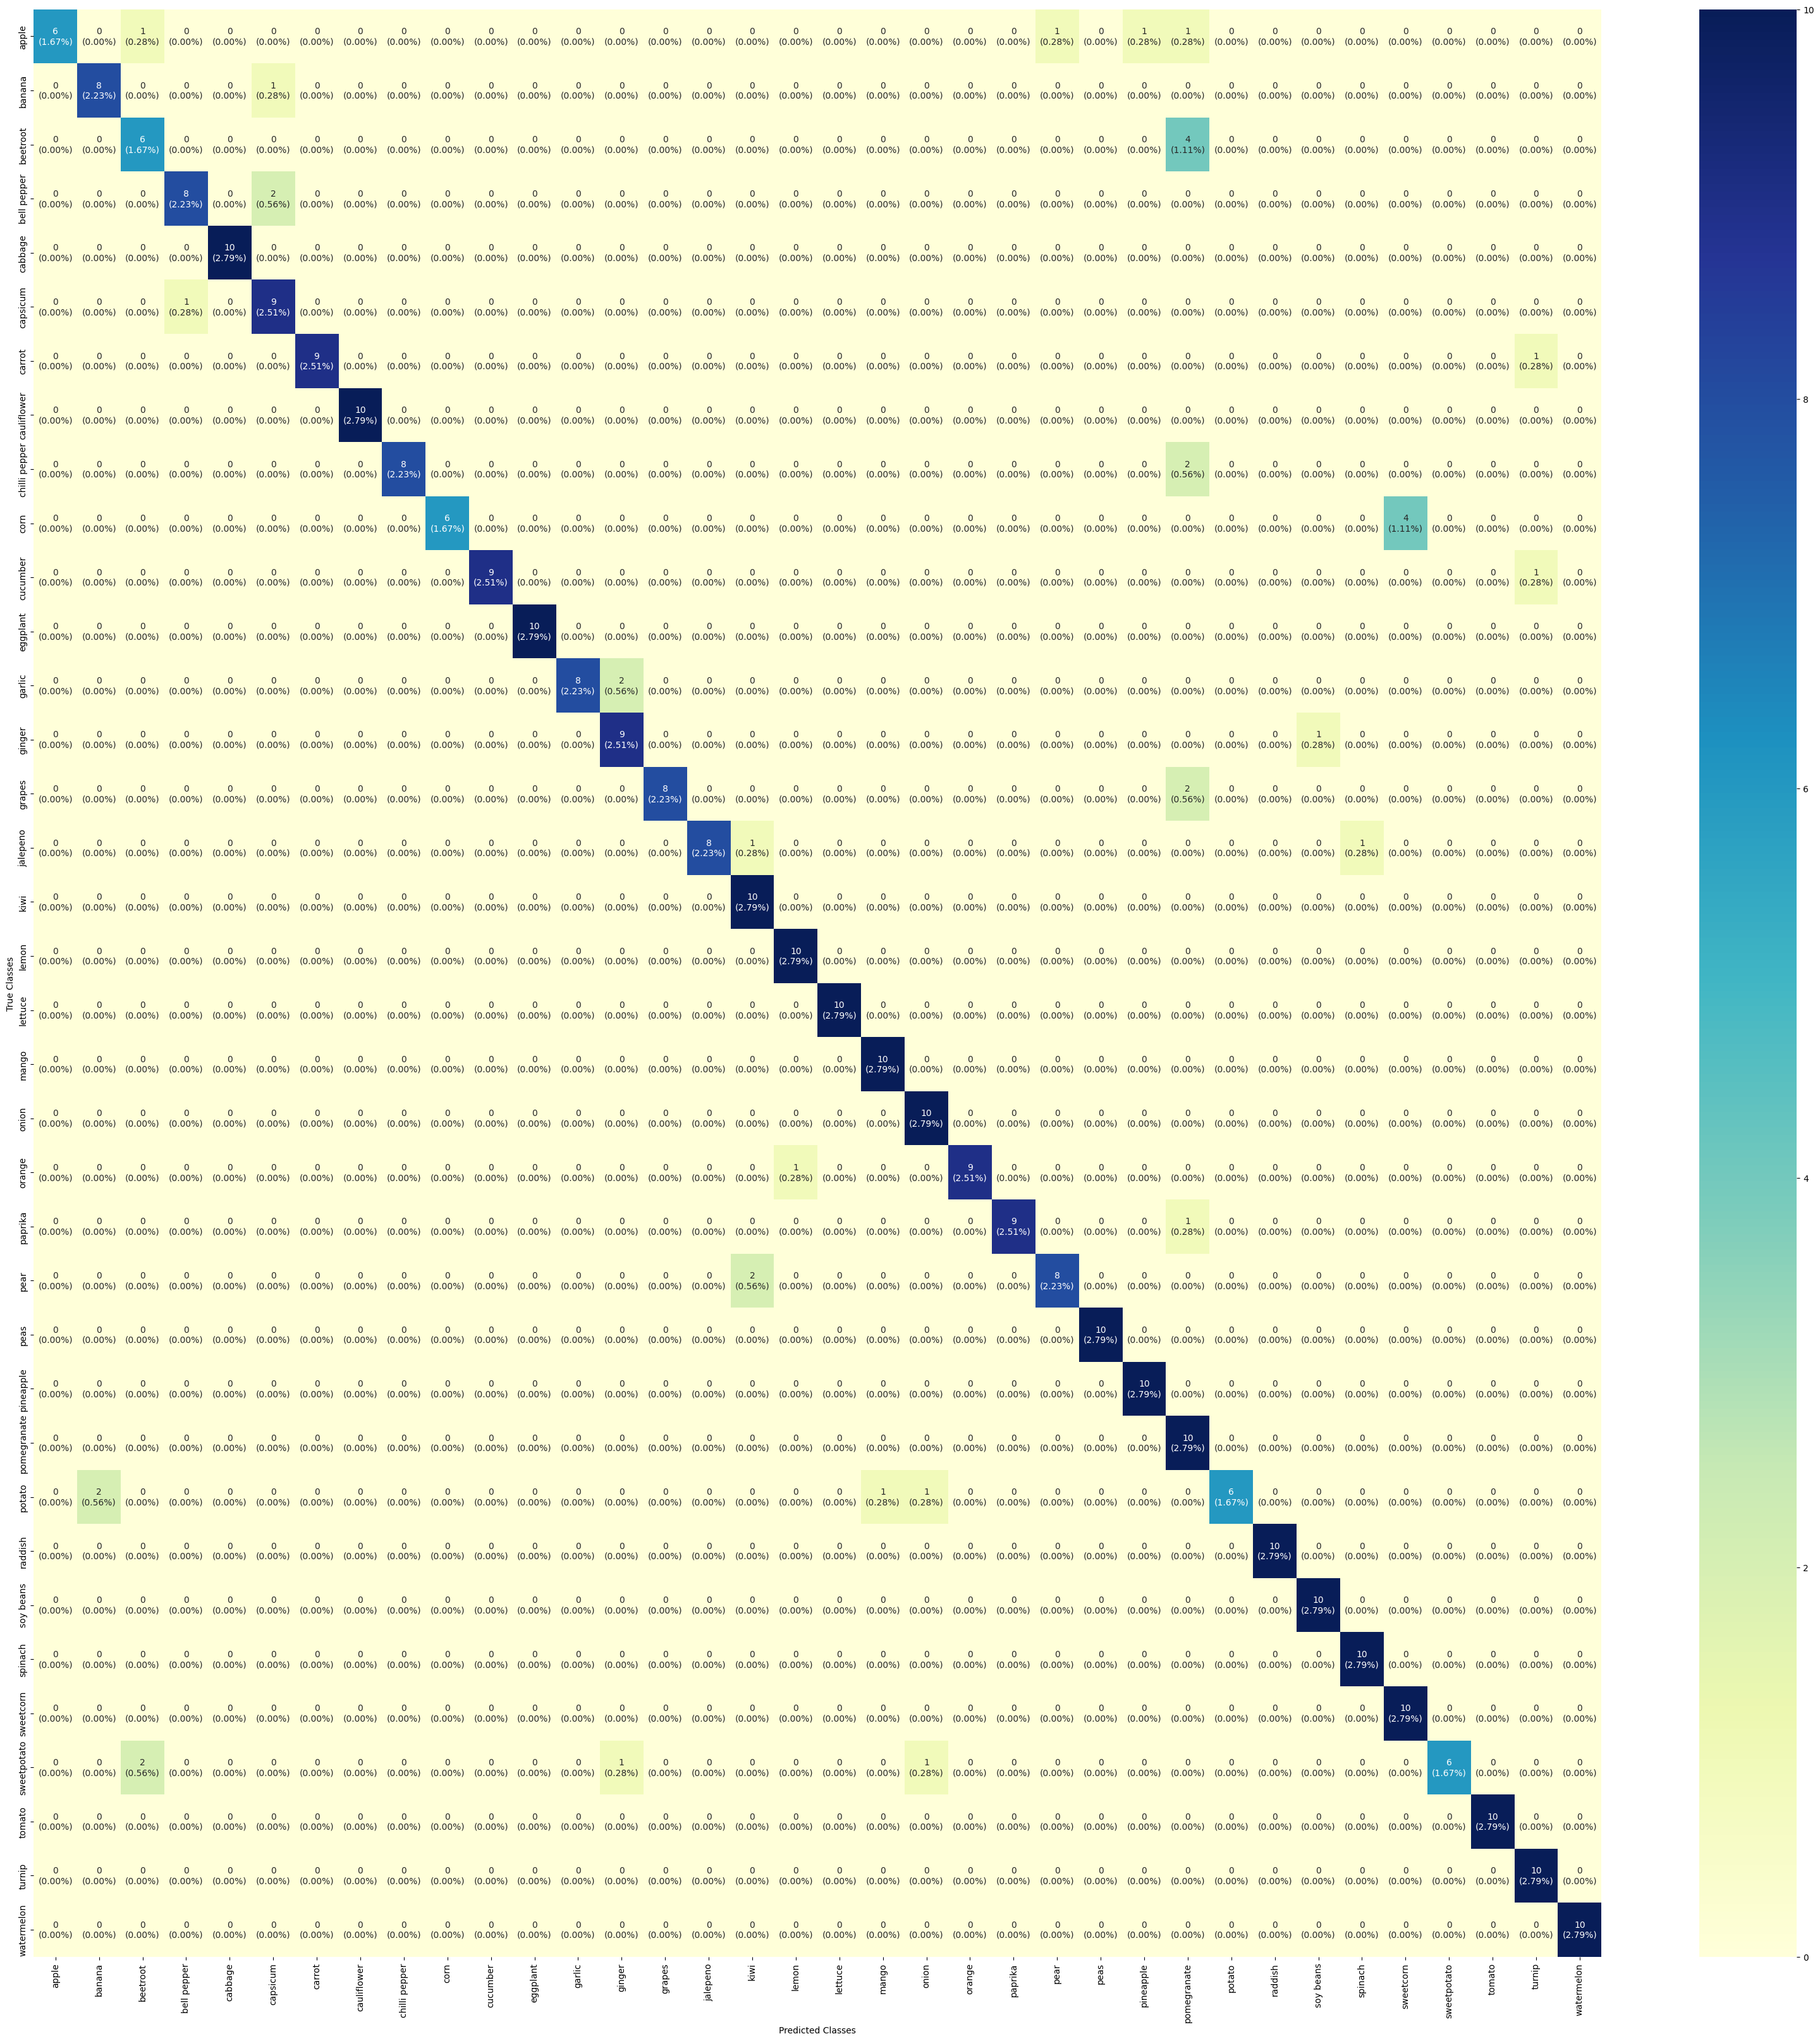

In [95]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(36, 36)

plt.figure(figsize = (40, 40))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [96]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

               precision    recall  f1-score   support

        apple       1.00      0.60      0.75        10
       banana       0.80      0.89      0.84         9
     beetroot       0.67      0.60      0.63        10
  bell pepper       0.89      0.80      0.84        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.75      0.90      0.82        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.80      0.89        10
         corn       1.00      0.60      0.75        10
     cucumber       1.00      0.90      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      0.80      0.89        10
       ginger       0.75      0.90      0.82        10
       grapes       1.00      0.80      0.89        10
     jalepeno       1.00      0.80      0.89        10
         kiwi       0.77      1.00      0.87        10
        l